In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
config = tf.ConfigProto()
config.gpu_options.visible_device_list='0'
sess = tf.InteractiveSession(config=config)

In [3]:
pkl_path = '../network-snapshot-005376.pkl'

In [4]:
with open(pkl_path, 'rb') as file:
    G, D, Gs, E = pickle.load(file)

In [17]:
path_l = './results/003-pgan-aiims_cc-preset-v2-2gpus-fp32-VERBOSE-GRAPH/256x256/000000.png'
path_r = '../aiims_cc_256/FILE00063333333.png'

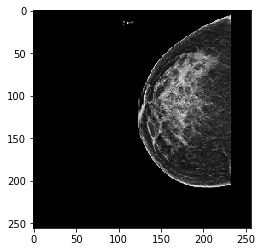

In [18]:
img_l = plt.imread( path_l )
plt.imshow( img_l, cmap = 'gray' )
plt.show()

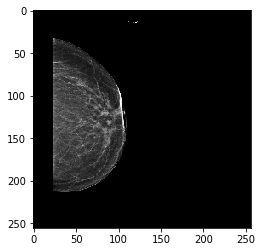

In [19]:
img_r = plt.imread( path_r )
plt.imshow( img_r, cmap = 'gray' )
plt.show()

In [8]:
def img_process():
    img_l = np.asarray( Image.open( path_l ), dtype=np.float32 )
    img_r = np.asarray( Image.open( path_r ), dtype=np.float32 )
    
    img_l = np.expand_dims( img_l, axis=2 )
    img_r = np.expand_dims( img_r, axis=2 )
    
    img_l = np.expand_dims( img_l, axis=0 )
    img_r = np.expand_dims( img_r, axis=0 )
    
    return img_l, img_r
    

In [20]:
## Read
X1, X2 = img_process()

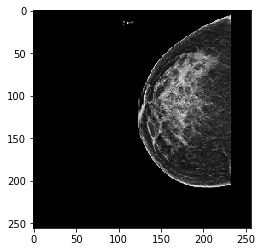

In [21]:
plt.imshow( np.squeeze(X1).astype(np.uint8), cmap='gray' )
plt.show()

In [11]:
def save_images_h(path, images, imagesPerRow=16):
    n, h, w, c = images.shape
    rows = int(n / imagesPerRow) + 1 * ((n % imagesPerRow) != 0)
    img = np.zeros((h * rows, w * imagesPerRow, c), dtype=np.float32)
    for idx, image in enumerate(images):
        i = idx % imagesPerRow
        j = idx // imagesPerRow
        img[j * h:j * h + h, i * w:i * w + w, :] = image
    return Image.fromarray(np.squeeze(img).astype('uint8')).save(path)

In [12]:
labels = np.zeros([1] + Gs.input_shapes[1][1:])

In [13]:
def get_img(latents):
    images = G.run(latents, labels)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    images = np.squeeze( images )
    return images

In [14]:
def get_interpolations(X1, X2, num, outfolder = ""):
    print('Calculating latent representations...')
    imgs1, imgs2 = X1, X2
    
    X1_new = X1.transpose(0, 3, 2, 1)
    X2_new = X2.transpose(0, 3, 2, 1)
    
    l1, l2 = E.run(X1_new), E.run(X2_new)
    img_inters = []
    e_range = np.linspace(0, 1., num)
    print('Calculating interpolated frames...')
    for i, e in enumerate(e_range):
        l = l1 * (1. - e) + l2 * e
        img = get_img(l)
        img_inters.append(img)
        print(i)
        
    return img_inters

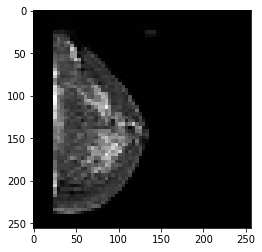

In [22]:
X1_new = X1.transpose(0, 3, 2, 1) 
l1 = E.run(X1_new)
img_x1 = get_img(l1)
plt.imshow( img_x1, cmap = 'gray' )
plt.show()

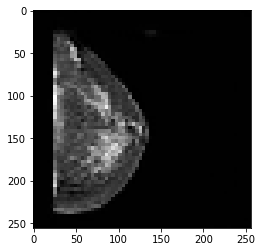

In [23]:
X2_new = X2.transpose(0, 3, 2, 1) 
l2 = E.run(X2_new)
img_x2 = get_img(l2)
plt.imshow( img_x2, cmap = 'gray' )
plt.show()

In [24]:
inter = get_interpolations(X1, X2, 16)

Calculating latent representations...
Calculating interpolated frames...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


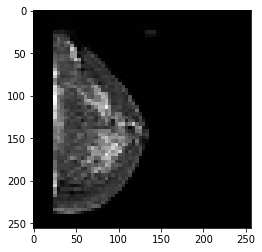

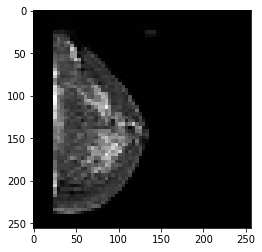

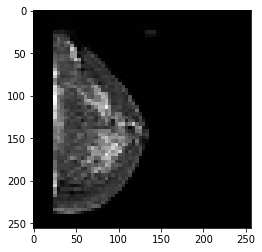

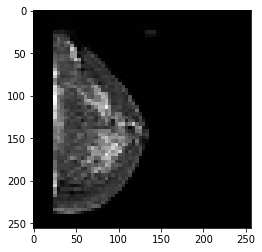

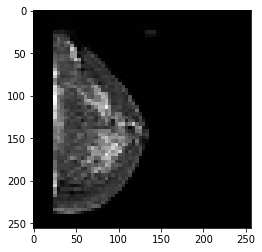

In [25]:
for i in range(5):
    plt.imshow( inter[0], cmap = 'gray' )
    plt.show()

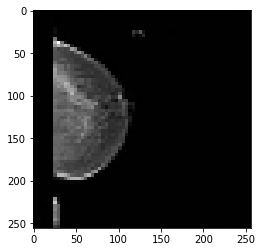

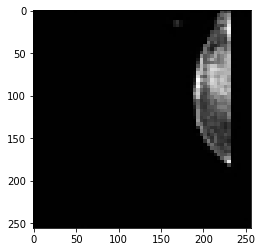

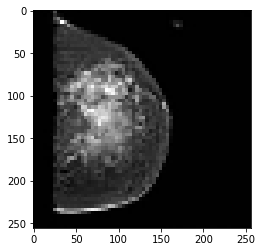

In [29]:
for _ in range(3):
    lat = np.random.uniform( -1.0, 1.0, (1,512)  )
    img = get_img(lat)
    plt.imshow( img, cmap = 'gray' )
    plt.show()

In [ ]:
print (l1 - l2)

In [27]:
l1_x = E.run( X1_new )
l2_y = E.run( X1_new )

In [ ]:
E.